# validation of quantities

In [5]:
import pickle
K = 4
L = 12
with open('../data/avnssDPD.pkl', 'rb') as f:
    avnssDPD = pickle.load(f)
with open('../data/neutralsets_NDPD.pkl', 'rb') as f:
    neutralsetsNDPD = pickle.load(f)

In [ ]:
from collections import Counter

defaultdict(float,
            {'............': 15361761.448333334,
             '...(.....)..': 13216651.906666666,
             '.(........).': 13271678.754999997,
             '((.......)).': 11108482.151666667,
             '..(((...))).': 8756771.642500002,
             '..((.....)).': 11123392.513333334,
             '...(....)...': 13132928.633333337,
             '..((......))': 10879666.491666663,
             '..(......)..': 13333906.876666661,
             '......(....)': 12746521.00666667,
             '.....((...))': 10313975.803333333,
             '....(.....).': 13013459.029166669,
             '((......))..': 11090163.699999996,
             '..(.......).': 13268502.054999992,
             '.((....))...': 11005291.544999998,
             '...(......).': 13151247.084999999,
             '(.......)...': 13114841.571666673,
             '...((...))..': 10850031.035833327,
             '(......)....': 12978350.658333335,
             '(.....).....': 12869676.04833334,
    

In [12]:
len(avnssDPD), len(neutralsetsNDPD)

(268, 271)

In [9]:
neutralsetsNDPD

defaultdict(float,
            {'............': 15361748.474743035,
             '(..........)': 12954858.588760598,
             '.(.........)': 13093348.433034783,
             '..(........)': 13090176.537193136,
             '...(.......)': 12972915.663893787,
             '....(......)': 12835138.452715281,
             '.....(.....)': 12750890.803552462,
             '......(....)': 12746519.631980218,
             '.......(...)': 12798912.78190502,
             '(.........).': 13133153.873488933,
             '.(........).': 13271643.717763124,
             '..(.......).': 13268471.821921477,
             '...(......).': 13151210.948622113,
             '....(.....).': 13013433.737443605,
             '.....(....).': 12929186.088280795,
             '......(...).': 12924814.916708551,
             '(.(.......))': 10861581.93593903,
             '((........))': 10864753.831780663,
             '.(.(......))': 10882810.90691386,
             '.((.......))': 11000071.78021323,
     

In [13]:
listav = []
listND = []
for key,val in avnssDPD.items():
    listav.append(val/K**L)
    listND.append(neutralsetsNDPD[key]/K**L)


[]

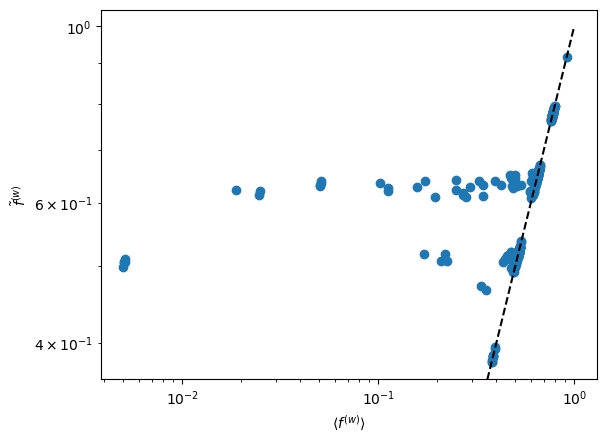

In [14]:
from matplotlib import pyplot as plt
plt.plot(listav, listND, 'o')
plt.xlabel(r'$\langle f^{(w)} \rangle$')
plt.ylabel(r'$\tilde{f}^{(w)}$')
plt.plot([0,1],[0,1], 'k--')
plt.loglog()

In [4]:
#robustness and evolvability
from collections import Counter
from collections import defaultdict
from itertools import product
import random

def normalize(probs):
    prob_factor = 1 / sum(probs)
    return [prob_factor * p for p in probs]

def mutationalneighbours(seq):
    mutations = {'A': ['C','U','G'],'C': ['A','U','G'],'G': ['A','U','C'], 'U':['A','G','C']}
    return [seq[:j] + m + seq[j+1:] for j in range(0,len(seq)) for m in mutations[str(seq[j])]]

def mutationalneighbours_site(seq,site):
    mutations = {'A': ['C','U','G'],'C': ['A','U','G'],'G': ['A','U','C'], 'U':['A','G','C']}
    return [seq[:site] + m + seq[site+1:] for m in mutations[str(seq[site])]]

def extractnormalisedprobs(pboltzlist,L):
    probsnorm = []
    for p in pboltzlist:
        probsnorm.append(float(p[L+2:]))
    prob = normalize(probsnorm)
    return {pboltzlist[pi][0:L]: prob[pi] for pi in range(0,len(pboltzlist))}

def mutation(seq,mu):
    basemutation = {'A': ['C','U','G'],'C': ['A','U','G'],'G': ['A','U','C'], 'U':['A','G','C']}
    for n in range(0,len(seq)):
        basemut = random.choices([1,0], weights=[mu,1-mu],k=1)[0]
        if basemut==1: #mutate a base
            mut = random.choices(basemutation[seq[n]],k=1)[0]
            p = seq[:n] + str(mut) + seq[n+1:]
            seq = p
    return seq


def hamming_vec(a,b):
        return sum(x!=y for x,y, in zip(list(a),list(b)))

def similarity(seq1,seq2):
    d = 0
    for i,j in zip(seq1,seq2):
        if i==j: 
            d+=1
    return d/len(seq1)

def hamming(seq1,seq2):
    d = 0
    for i,j in zip(seq1,seq2):
        if i!=j: 
            d+=1
    return d/len(seq1)
def robustnessD_PD(d,folds,K,L):
    s = list(d.keys())
    a = Counter(folds)
    rho_g_pd = {}
    for A in d.keys():
        rho_g_pd[A[0:L]] = 0
    rho_p_pd = {}
    for A in a.keys():
        rho_p_pd[A[0:L]] = 0
    for seq in d.keys():
        for mut in mutationalneighbours(seq):
                rho_g_pd[seq] += similarity(d[seq],d[mut])/((K-1)*L)

    for fold,count in a.items():
        for j in range(0,len(folds)):
            if fold[0:L]==folds[j][0:L]:
                rho_p_pd[fold[0:L]]+=rho_g_pd[s[j]]
        rho_p_pd[fold[0:L]]/= count

    return rho_g_pd,rho_p_pd

def evolvabilitygD_PD(gpmapdet):
    evgdictd = defaultdict(float)
    for seq,p in gpmapdet.items():
            prodfold = defaultdict(lambda:1)
            for newmutation in mutationalneighbours(seq):
                    foldmut=gpmapdet[newmutation]
                    if foldmut != p:
                        prodfold[foldmut] *=0
                    else: prodfold[foldmut]*=1
            for foldmut,pprime in prodfold.items():
                evgdictd[seq]+=hamming(p,foldmut)*(1-pprime)
    return evgdictd

def evolvabilitypD_PD(dictRNA12):
    evolp = defaultdict(float)
    prodfold = defaultdict(lambda:1) # I am assuming this is the product part - I have changed it so that this collects the data for all p&p' pairs
    for seq, phenotype in dictRNA12.items(): #by arranging the loops in this way, the slow part (extractnormalisedprobs(gpmap[seq],L)) is executed fewer times
        for newmutation in mutationalneighbours(seq):
            phenotypeprime = dictRNA12[newmutation]
            if phenotypeprime!= phenotype:
                prodfold[(phenotype, phenotypeprime)] *=0

    for (phenotype, phenotypeprime), val in prodfold.items():
        evolp[phenotype] +=hamming(phenotype,phenotypeprime)*(1-val)

    return evolp

def robustnessD(DGPmap,folds,K,L):   
    s = list(DGPmap.keys())
    a = Counter(folds)
    rho_g = {}
    for A in DGPmap.keys():
        rho_g[A[0:L]] = 0
    rho_p = {}
    for A in a.keys():
        rho_p[A[0:L]] = 0
    #genotypic robustness
    for seq in DGPmap.keys():
        for mut in mutationalneighbours(seq):
                if (DGPmap[mut]==DGPmap[seq]):rho_g[seq]+=1/((K-1)*L)
                else: continue
    #phenotypic robustness
    for fold,count in a.items():
        for j in range(0,len(folds)):
            if fold[0:L]==folds[j][0:L]:
                rho_p[fold[0:L]]+=rho_g[s[j]]
        rho_p[fold[0:L]]/= count
    
    return rho_g,rho_p

def evolvabilitygD(DGPmap):
    evgdictd = defaultdict(float)
    for seq,p in DGPmap.items():
            prodfold = defaultdict(lambda:1)
            for newmutation in mutationalneighbours(seq):            
                    foldmut=DGPmap[newmutation]
                    if foldmut != p:
                        prodfold[foldmut] *=0
                    else: prodfold[foldmut]*=1
            for pprime in prodfold.values():
                evgdictd[seq]+=(1-pprime)
    return evgdictd

def evolvabilitypD(DGPmap):
    evolp = defaultdict(float)
    prodfold = defaultdict(lambda:1) 
    for seq, phenotype in DGPmap.items():
        for newmutation in mutationalneighbours(seq):                    
            phenotypeprime = DGPmap[newmutation]
            if phenotypeprime!= phenotype:
                prodfold[(phenotype, phenotypeprime)] *=0

    for (phenotype, phenotypeprime), val in prodfold.items():
        evolp[phenotype] += (1-val)

    return evolp


In [6]:
import pickle
with open("../data/DGPmap.pkl","rb") as f:
    DGPmap = pickle.load(f)
L=12
K=4

In [ ]:
with open("../data/rhogDPD.pkl","rb") as f:
    rhogDPD = pickle.load(f)
#with open("../data/rhopDPD.pkl","rb") as f:
#    rhopDPD = pickle.load(f)


In [8]:
with open('../data/evgDPD.pkl', 'rb') as f:
    evgDPD = pickle.load(f)
with open('../data/evpDPD.pkl', 'rb') as f:
    evpDPD = pickle.load(f)

In [5]:
rhogD,rhopD = robustnessD(DGPmap, list(DGPmap.values()), K, L)

In [6]:
#with open('../data/rhogD.pkl', 'wb') as f:
#    pickle.dump(rhogD, f)
with open('../data/rhopD.pkl', 'wb') as f:
    pickle.dump(rhopD, f)

In [12]:
evgD = evolvabilitygD(DGPmap)
#evpD = evolvabilitypD(DGPmap)

In [13]:
with open("../data/evgD.pkl","wb") as f:
    pickle.dump(evgD,f)

In [8]:
with open("../data/evpD.pkl","wb") as f:
    pickle.dump(evpD,f)

In [ ]:
with open("../data/rhogD.pkl","wb") as f:
    pickle.dump(rhogD,f)
with open("../data/rhopD.pkl","wb") as f:
    pickle.dump(rhopD,f)

NameError: name 'pickle' is not defined

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(5, 5))  # Adjusted height for better spacing
gs = GridSpec(2, 2, figure=fig)

# Subplot 1: Genotypic robustness
ax1 = fig.add_subplot(gs[0, 0])
sorted_keys = sorted(rhogDPD.keys())
aligned_rhogDPD_values = [rhogDPD[key] for key in sorted_keys]
aligned_rhogD_values = [rhogD[key] for key in sorted_keys]
ax1.plot(aligned_rhogDPD_values, aligned_rhogD_values, '+', color='black', markersize=5)
ax1.set_title('Genotypic robustness')
ax1.set_xlabel(r'$\rho_g^{(w)}$', fontsize=15)
ax1.set_ylabel(r'$\rho_g$', fontsize=15)
ax1.plot([0, 1], [0, 1], 'k--')

# Subplot 2: Phenotypic robustness
ax2 = fig.add_subplot(gs[0, 1])
sorted_keys = sorted(rhopDPD.keys())
aligned_rhopDPD_values = [rhopDPD[key] for key in sorted_keys]
aligned_rhopD_values = [rhopD[key] for key in sorted_keys]
ax2.plot(aligned_rhopDPD_values, aligned_rhopD_values, '+', color='black', markersize=5)
ax2.set_title('Phenotypic robustness')
ax2.set_xlabel(r'$\rho_p^{(w)}$', fontsize=15)
ax2.set_ylabel(r'$\rho_p$', fontsize=15)
ax2.plot([0, 1], [0, 1], 'k--')

# Subplot 3: Genotypic evolvability
ax3 = fig.add_subplot(gs[1, 0])
sorted_keys = sorted(evgDPD.keys())
aligned_evgDPD_values = [evgDPD[key] for key in sorted_keys]
aligned_evgD_values = [evgD[key] for key in sorted_keys]
ax3.plot(aligned_evgDPD_values, aligned_evgD_values, '+', color='black', markersize=5)
ax3.set_title('Genotypic evolvability')
ax3.set_xlabel(r'$e_g^{(w)}$', fontsize=15)
ax3.set_ylabel(r'$e_g$', fontsize=15)
ax3.plot([0, 20], [0, 20], 'k--')

# Subplot 4: Phenotypic evolvability
ax4 = fig.add_subplot(gs[1, 1])
sorted_keys = sorted(evpDPD.keys())
aligned_evpDPD_values = [evpDPD[key] for key in sorted_keys]
aligned_evpD_values = [evpD[key] for key in sorted_keys]
ax4.plot(aligned_evpDPD_values, aligned_evpD_values, '+', color='black', markersize=5)
ax4.set_title('Phenotypic evolvability')
ax4.set_xlabel(r'$e_p^{(w)}$', fontsize=15)
ax4.set_ylabel(r'$e_p$', fontsize=15)
ax4.plot([0, 50], [0,50], 'k--')

# Adjust layout
plt.tight_layout()
plt.savefig('../plots/robustness_evolvability.pdf',bbox_inches='tight')
#pickle.dump(fig,open('../plots/quant.pkl','wb'))

OSError: [Errno 28] No space left on device

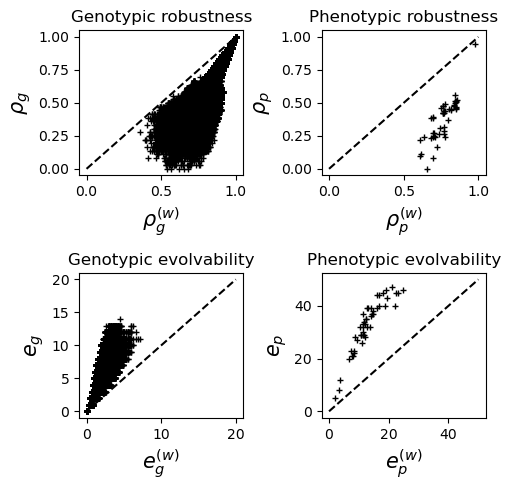

: 

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(5, 5))  # Adjusted height for better spacing
gs = GridSpec(2, 2, figure=fig)

# Subplot 1: Genotypic robustness
ax1 = fig.add_subplot(gs[0, 0])
sorted_keys = sorted(rhogDPD.keys())
aligned_rhogDPD_values = [rhogDPD[key] for key in sorted_keys]
aligned_rhogD_values = [rhogD[key] for key in sorted_keys]
ax1.plot(aligned_rhogDPD_values, aligned_rhogD_values, '+', color='black', markersize=5)
ax1.set_title('Genotypic robustness')
ax1.set_xlabel(r'$\rho_g^{(w)}$', fontsize=15)
ax1.set_ylabel(r'$\rho_g$', fontsize=15)
ax1.plot([0, 1], [0, 1], 'k--')

# Subplot 2: Phenotypic robustness
ax2 = fig.add_subplot(gs[0, 1])
sorted_keys = sorted(rhopDPD.keys())
aligned_rhopDPD_values = [rhopDPD[key] for key in sorted_keys]
aligned_rhopD_values = [rhopD[key] for key in sorted_keys]
ax2.plot(aligned_rhopDPD_values, aligned_rhopD_values, '+', color='black', markersize=5)
ax2.set_title('Phenotypic robustness')
ax2.set_xlabel(r'$\rho_p^{(w)}$', fontsize=15)
ax2.set_ylabel(r'$\rho_p$', fontsize=15)
ax2.plot([0, 1], [0, 1], 'k--')

# Subplot 3: Genotypic evolvability
ax3 = fig.add_subplot(gs[1, 0])
sorted_keys = sorted(evgDPD.keys())
aligned_evgDPD_values = [evgDPD[key] for key in sorted_keys]
aligned_evgD_values = [evgD[key] for key in sorted_keys]
ax3.plot(aligned_evgDPD_values, aligned_evgD_values, '+', color='black', markersize=5)
ax3.set_title('Genotypic evolvability')
ax3.set_xlabel(r'$e_g^{(w)}$', fontsize=15)
ax3.set_ylabel(r'$e_g$', fontsize=15)
ax3.plot([0, 20], [0, 20], 'k--')

# Subplot 4: Phenotypic evolvability
ax4 = fig.add_subplot(gs[1, 1])
sorted_keys = sorted(evpDPD.keys())
aligned_evpDPD_values = [evpDPD[key] for key in sorted_keys]
aligned_evpD_values = [evpD[key] for key in sorted_keys]
ax4.plot(aligned_evpDPD_values, aligned_evpD_values, '+', color='black', markersize=5)
ax4.set_title('Phenotypic evolvability')
ax4.set_xlabel(r'$e_p^{(w)}$', fontsize=15)
ax4.set_ylabel(r'$e_p$', fontsize=15)
ax4.plot([0, 50], [0,50], 'k--')

# Adjust layout
plt.tight_layout()
plt.savefig('../plots/robustness_evolvability.pdf',bbox_inches='tight')
#pickle.dump(fig,open('../plots/quant.pkl','wb'))

# structural properties

In [1]:
from collections import Counter
import pickle

with open('../data/evpDPD.pkl', 'rb') as f:
    evpDPD = pickle.load(f)
with open('../data/rhopDPD.pkl', 'rb') as f:
    rhopDPD = pickle.load(f)
with open('../data/evgDPD.pkl', 'rb') as f:
    evgDPD = pickle.load(f)
with open('../data/rhogDPD.pkl', 'rb') as f:
    rhogDPD = pickle.load(f)
with open('../data/evgD.pkl', 'rb') as f:
    evgD = pickle.load(f)
with open('../data/rhogD.pkl', 'rb') as f:
    rhogD = pickle.load(f)
with open('../data/evpD.pkl', 'rb') as f:
    evpD = pickle.load(f)
with open('../data/rhopD.pkl', 'rb') as f:
    rhopD = pickle.load(f)
with open("../data/DGPmap.pkl","rb") as f:
    DGPmap = pickle.load(f)
with open('../data/neutralsets_NDPD.pkl', 'rb') as f:
    neutralsetsNDPD = pickle.load(f)
neutralsets = Counter(DGPmap.values())

L=12
K=4

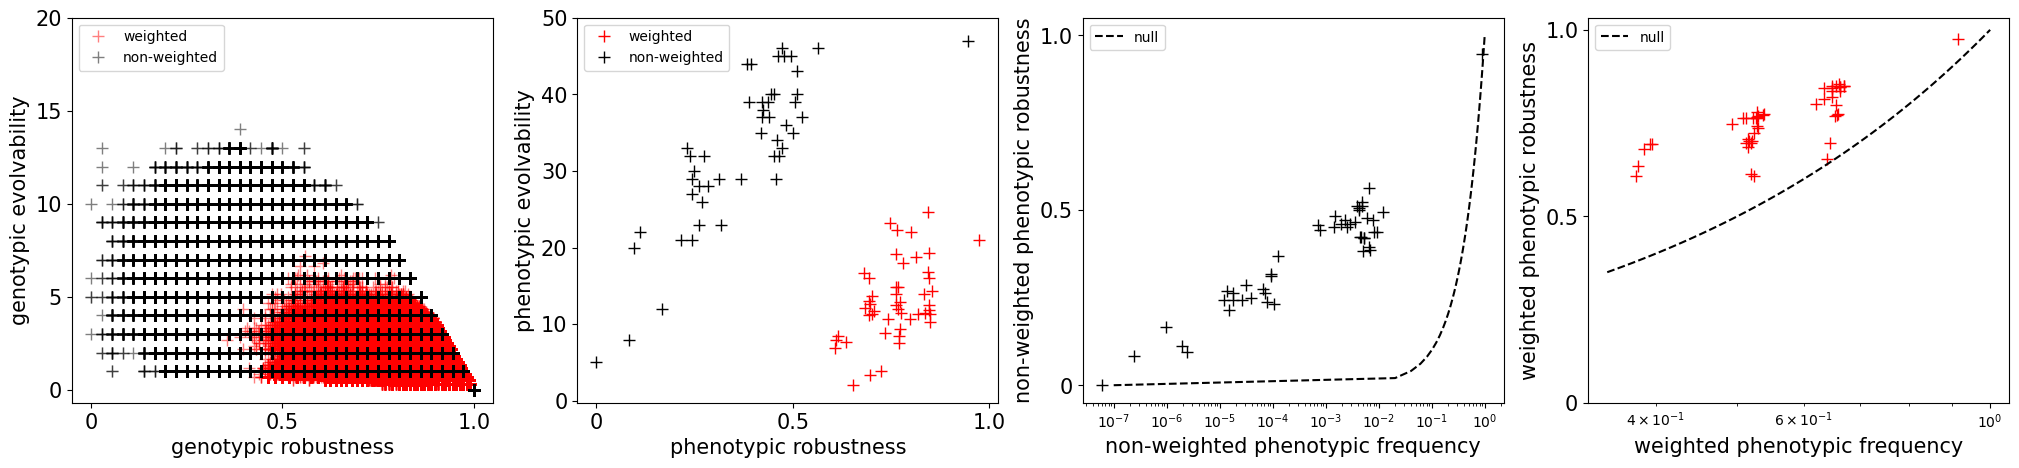

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import gridspec

fig = plt.figure(figsize=(25, 5))  # Adjusted height for better spacing
gs = gridspec.GridSpec(1, 4, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
sorted_keys = sorted(rhogDPD.keys())
#aligned_rhogDPD_values = [rhogDPD[key] for key in sorted_keys]
#aligned_evgDPD_values = [evgDPD[key] for key in sorted_keys]
#sorted_keys = sorted(rhogD.keys())
#aligned_evg_values = [evgD[key] for key in sorted_keys]
#aligned_rhog_values = [rhogD[key] for key in sorted_keys]
ax1.plot(list(rhogDPD.values()), list(evgDPD.values()), '+', color='red', markersize=8,label='weighted',alpha=0.5)
ax1.plot(list(rhogD.values()), list(evgD.values()), '+', color='black', markersize=8,label='non-weighted',alpha=0.5)
ax1.set_yticks([0, 5,10,15,20])
ax1.set_yticklabels([0, 5,10,15,20], fontsize=15)
ax1.set_xticks([0, 0.5,1.0])
ax1.set_xticklabels([0,0.5,1.0], fontsize=15)
ax1.set_xlabel(r'genotypic robustness', fontsize=15)
ax1.set_ylabel(r'genotypic evolvability', fontsize=15)
plt.legend(loc='upper left', fontsize=10)

# Subplot 1: Genotypic robustness
ax2 = fig.add_subplot(gs[0, 1])
sorted_keys = sorted(rhopDPD.keys())
aligned_rhopDPD_values = [rhopDPD[key] for key in sorted_keys]
aligned_evpDPD_values = [evpDPD[key] for key in sorted_keys]
sorted_keys = sorted(rhopD.keys())
aligned_evp_values = [evpD[key] for key in sorted_keys]
aligned_rhop_values = [rhopD[key] for key in sorted_keys]
ax2.plot(aligned_rhopDPD_values, aligned_evpDPD_values, '+', color='red', markersize=8,label='weighted')
ax2.plot(aligned_rhop_values, aligned_evp_values, '+', color='black', markersize=8,label='non-weighted')
ax2.set_yticks([0, 10, 20, 30, 40, 50])
ax2.set_yticklabels([0, 10, 20, 30, 40, 50], fontsize=15)
ax2.set_xticks([0, 0.5,1.0])
ax2.set_xticklabels([0,0.5,1.0], fontsize=15)
ax2.set_xlabel(r'phenotypic robustness', fontsize=15)
ax2.set_ylabel(r'phenotypic evolvability', fontsize=15)
plt.legend(loc='upper left', fontsize=10)


ax3 = fig.add_subplot(gs[0, 2])
sorted_keys = sorted(rhopDPD.keys())
aligned_rhopDPD_values = [rhopDPD[key] for key in sorted_keys]
aligned_fDPD_values = [neutralsetsNDPD[key] for key in sorted_keys]
sorted_keys = sorted(rhopD.keys())
aligned_f_values = [neutralsets[key] for key in sorted_keys]
#ax2.plot( aligned_fDPD_values,aligned_rhopDPD_values, '+', color='red', markersize=5,label='weighted')
ax3.plot(np.array(aligned_f_values)/K**L,aligned_rhop_values, '+', color='black', markersize=8)
ax3.plot(np.linspace(1e-7, 1), np.linspace(1e-7, 1), color='black', linestyle='--',label='null')
plt.legend(loc='upper left', fontsize=10)
ax3.set_ylabel(r'non-weighted phenotypic robustness', fontsize=15)
ax3.set_xlabel(r'non-weighted phenotypic frequency', fontsize=15)
ax3.set_yticks([0,0.5,1.0])
ax3.set_yticklabels([0,0.5,1.0], fontsize=15)
ax3.set_xscale('log')
ax3.set_yticks([0, 0.5, 1])


ax4 = fig.add_subplot(gs[0, 3])
ax4.plot(np.array(aligned_fDPD_values)/K**L,aligned_rhopDPD_values, '+', color='red', markersize=8,)
ax4.plot(np.linspace(0.35, 1), np.linspace(0.35, 1), color='black', linestyle='--', label = 'null')
plt.legend(loc='upper left', fontsize=10)
ax4.set_xscale('log')
ax4.set_yticks([0,0.5,1.0])
ax4.set_yticklabels([0,0.5,1.0], fontsize=15)
ax4.set_ylabel(r'weighted phenotypic robustness', fontsize=15)
ax4.set_xlabel(r'weighted phenotypic frequency', fontsize=15)
ax4.set_yticks([0, 0.5, 1])

pearson_rPD = np.corrcoef(aligned_rhopDPD_values, aligned_evpDPD_values)[0, 1]
pearson_rD = np.corrcoef(aligned_rhop_values, aligned_evp_values)[0, 1]
#plt.savefig('../plots/robustness_evolvability_phenotypic.pdf',bbox_inches='tight')
plt.savefig('../plots/robustness_evolvability_structure.png',bbox_inches='tight', dpi=300)

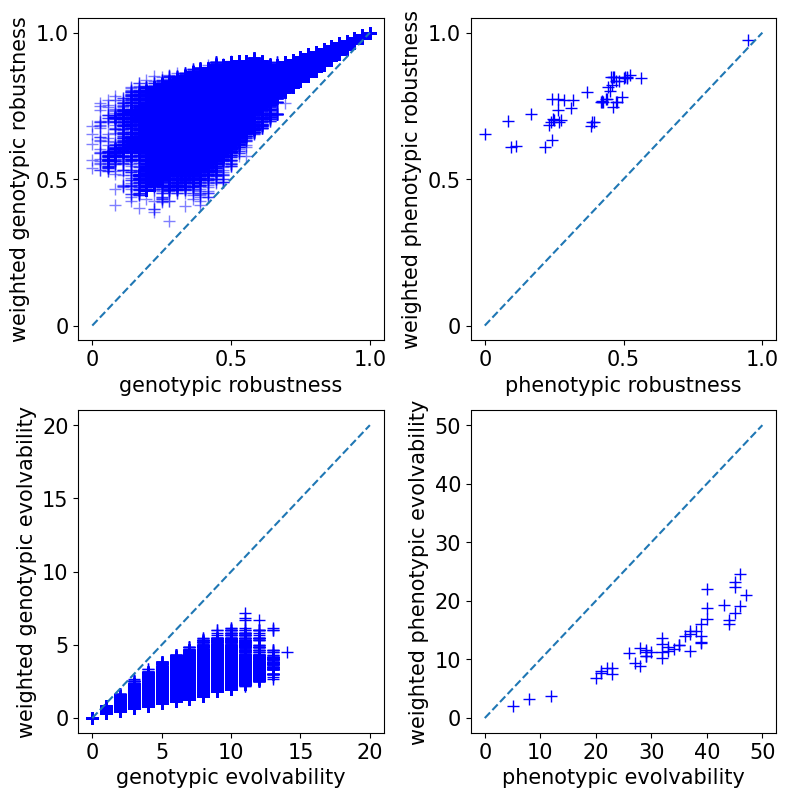

In [8]:
from matplotlib import pyplot as plt
from matplotlib import gridspec
import numpy as np
fig = plt.figure(figsize=(8, 8))  # Adjusted height for better spacing
gs = gridspec.GridSpec(2, 2, figure=fig)
# Subplot 1: Genotypic robustness
ax1 = fig.add_subplot(gs[0, 0])
sorted_keys = sorted(rhogDPD.keys())

ax1.plot(list(rhogD.values()), list(rhogDPD.values()), '+', color='blue', markersize=8, alpha=0.5)
ax1.plot([0, 1], [0, 1], '--')
ax1.set_yticks([0, 0.5, 1.0])
ax1.set_yticklabels([0, 0.5, 1.0], fontsize=15)
ax1.set_xticks([0, 0.5, 1.0])
ax1.set_xticklabels([0, 0.5, 1.0], fontsize=15)
ax1.set_xlabel(r'genotypic robustness', fontsize=15)
ax1.set_ylabel(r'weighted genotypic robustness', fontsize=15)
# Subplot 1: Genotypic robustness
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(list(rhopD.values()), list(rhopDPD.values()), '+', color='blue', markersize=8)
ax2.plot([0, 1], [0, 1], '--')
ax2.set_yticks([0, 0.5, 1.0])
ax2.set_yticklabels([0, 0.5, 1.0], fontsize=15)
ax2.set_xticks([0, 0.5, 1.0])
ax2.set_xticklabels([0, 0.5, 1.0], fontsize=15)
ax2.set_xlabel(r'phenotypic robustness', fontsize=15)
ax2.set_ylabel(r'weighted phenotypic robustness', fontsize=15)
# Subplot 3: Genotypic evolvability
ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(list(evgD.values()), list(evgDPD.values()), '+', color='blue', markersize=8)
ax3.plot([0, 20], [0, 20], '--')
ax3.set_yticks([0, 5,10,15,20])
ax3.set_yticklabels([0, 5,10,15,20], fontsize=15)
ax3.set_xticks([0, 5,10,15,20])
ax3.set_xticklabels([0, 5,10,15,20], fontsize=15)
ax3.set_xlabel(r'genotypic evolvability', fontsize=15)
ax3.set_ylabel(r'weighted genotypic evolvability', fontsize=15)
# Subplot 4: Phenotypic evolvability
ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(list(evpD.values()), list(evpDPD.values()), '+', color='blue', markersize=8)
ax4.plot([0, 50], [0, 50], '--')
ax4.set_yticks([0, 10, 20, 30, 40, 50])
ax4.set_yticklabels([0, 10, 20, 30, 40, 50], fontsize=15)
ax4.set_xticks([0, 10, 20, 30, 40, 50])
ax4.set_xticklabels([0, 10, 20, 30, 40, 50], fontsize=15)
ax4.set_xlabel(r'phenotypic evolvability', fontsize=15)
ax4.set_ylabel(r'weighted phenotypic evolvability', fontsize=15)
plt.tight_layout()
plt.savefig('../plots/robustness_evolvability_compare.png',bbox_inches='tight', dpi=300)

In [2]:
from collections import defaultdict
fractionaladd = defaultdict(float)
for rhopkey in rhopD.keys():
    fractionaladd[rhopkey] = rhopDPD[rhopkey] - rhopD[rhopkey]
fractionalsub = defaultdict(float)
for evpkey in evpD.keys():
    fractionalsub[evpkey] = -(evpDPD[evpkey] - evpD[evpkey])
    

In [3]:
from collections import defaultdict
fractionaladdg = defaultdict(float)
for rhogkey in rhogD.keys():
    fractionaladdg[rhogkey] = rhogDPD[rhogkey] - rhogD[rhogkey]
fractionalsubg = defaultdict(float)
for evgkey in evgD.keys():
    fractionalsubg[evgkey] = -(evgDPD[evgkey] - evgD[evgkey])

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import gridspec
import numpy as np
fig = plt.figure(figsize=(5, 5))  # Adjusted height for better spacing
gs = gridspec.GridSpec(2, 2, figure=fig)
# Subplot 1: Genotypic robustness
ax1 = fig.add_subplot(gs[0, 0])
sorted_keys = sorted(rhogDPD.keys())

ax1.plot(list(rhogD.values()), list(fractionaladdg.values()), '+', color='blue', markersize=8, alpha=0.5)
#ax1.plot([0, 1], [0, 1], '--')
ax1.set_title('Pearson r: %.2f' % pearson_rg)
ax1.set_yticks([0, 0.5, 1.0])
ax1.set_yticklabels([0, 0.5, 1.0], fontsize=15)
ax1.set_xticks([0, 0.5, 1.0])
ax1.set_xticklabels([0, 0.5, 1.0], fontsize=15)
ax1.set_ylabel(r'$\langle s \rangle_{\mathcal{N}_g}$', fontsize=15)
ax1.set_xlabel(r'$\rho_g$', fontsize=15)
# Subplot 1: Genotypic robustness
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(list(rhopD.values()), list(fractionaladd.values()), '+', color='blue', markersize=8)
ax2.set_title('Pearson r: %.2f' % pearson_r)
#ax2.plot([0, 1], [0, 1], '--')
ax2.set_yticks([0, 0.5, 1.0])
ax2.set_yticklabels([0, 0.5, 1.0], fontsize=15)
ax2.set_xticks([0, 0.5, 1.0])
ax2.set_xticklabels([0, 0.5, 1.0], fontsize=15)
ax2.set_ylabel(r'$\langle s \rangle_{\mathcal{N}_p}$', fontsize=15)
ax2.set_xlabel(r'$\rho_p$', fontsize=15)
# Subplot 3: Genotypic evolvability
ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(list(evgD.values()), 1- np.array(list(fractionalsubg.values()))/np.array(list(evgD.values())), '+', color='blue', markersize=8)
#ax3.set_title('Pearson r: %.2f' % pearson_r2g)
#ax3.plot([0, 20], [0, 20], '--')
#ax3.set_yticks([0, 5,10,15,20])
#ax3.set_yticklabels([0, 5,10,15,20], fontsize=15)
#ax3.set_xticklabels([0, 5,10,15,20], fontsize=15)
#ax3.set_xticks([0, 5,10,15,20])
ax3.set_ylabel(r'$\langle H \rangle_{{\mathcal{N}_g^*}}$', fontsize=15)
ax3.set_xlabel(r'$e_g$', fontsize=15)
# Subplot 4: Phenotypic evolvability
ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(list(evpD.values()), 1-np.array(list(fractionalsub.values()))/np.array(list(evpD.values())), '+', color='blue', markersize=8)
ax4.set_title('Pearson r: %.2f' % pearson_r2)
#ax4.plot([0, 50], [0, 50], '--')
#ax4.set_yticks([0, 10, 20, 30, 40, 50])
#ax4.set_yticklabels([0, 10, 20, 30, 40, 50], fontsize=15)
#ax4.set_xticks([0, 10, 20, 30, 40, 50])
#ax4.set_xticklabels([0, 10, 20, 30, 40, 50], fontsize=15)
ax4.set_xlabel(r'$e_p$', fontsize=15)
ax4.set_ylabel(r'$\langle H \rangle_{{\mathcal{N}_p^*}}$', fontsize=15)
plt.tight_layout()
plt.savefig('../plots/robustness_evolvability_compare2.png',bbox_inches='tight', dpi=300)

/tmp/ipykernel_452818/965681564.py:32: RuntimeWarning: invalid value encountered in divide
  ax3.plot(list(evgD.values()), 1- np.array(list(fractionalsubg.values()))/np.array(list(evgD.values())), '+', color='blue', markersize=8)


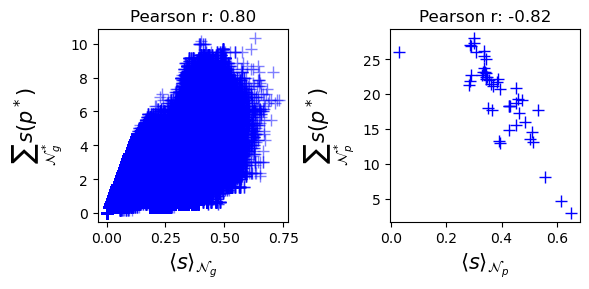

In [19]:
from matplotlib import pyplot as plt
from matplotlib import gridspec
import numpy as np
fig = plt.figure(figsize=(6, 3))  # Adjusted height for better spacing
gs = gridspec.GridSpec(1, 2, figure=fig)
# Subplot 1: Genotypic robustness
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title('Pearson r: %.2f' % pearson_rsg)
ax1.plot(list(fractionaladdg.values()), list(fractionalsubg.values()),'+', color='blue', markersize=8, alpha=0.5)
ax1.set_xlabel(r'$\langle s \rangle_{\mathcal{N}_g}$', fontsize=15)
ax1.set_ylabel(r'$\sum_{\mathcal{N}_g^*} s(p^*)$', fontsize=15)

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title('Pearson r: %.2f' % pearson_rsp)
ax2.plot(list(fractionaladd.values()), list(fractionalsub.values()),  '+', color='blue', markersize=8)
ax2.set_xlabel(r'$\langle s \rangle_{\mathcal{N}_p}$', fontsize=15)
ax2.set_ylabel(r'$\sum_{\mathcal{N}_p^*} s(p^*)$', fontsize=15)

plt.tight_layout()
plt.savefig('../plots/robustness_evolvability_compare3.png',bbox_inches='tight', dpi=300)

In [ ]:
from scipy.stats import pearsonr
import numpy as np
pearson_rg,corr = pearsonr(list(fractionaladdg.values()), list(rhogD.values()))
pearson_r2g,corr = pearsonr(1-np.array(list(fractionalsubg.values()))/np.array(list(evgD.values())), list(evgD.values()))

/tmp/ipykernel_452818/148423322.py:4: RuntimeWarning: invalid value encountered in divide
  pearson_r2g,corr = pearsonr(1-np.array(list(fractionalsubg.values()))/np.array(list(evgD.values())), list(evgD.values()))


ValueError: array must not contain infs or NaNs

In [ ]:
pearson_rg, pearson_r2g

(-0.9818190229877134, -0.9761545164086229)

In [11]:
from scipy.stats import pearsonr
pearson_r, corr= pearsonr(list(fractionaladd.values()), list(rhopD.values()))
pearson_r2, corr = pearsonr(1-np.array(list(fractionalsub.values()))/np.array(list(evpD.values())), list(evpD.values()))

In [ ]:
print("Pearson correlation for fractional additivity in robustness:", pearson_r)
print("Pearson correlation for fractional additivity in evolvability:", pearson_r2)

Pearson correlation for fractional additivity in robustness: -0.916099233749193
Pearson correlation for fractional additivity in evolvability: -0.933633488924238


In [4]:
pearson_rPD, pearson_rD

(0.48698998557901246, 0.8179609515673683)

In [17]:
from scipy.stats import pearsonr
pearson_rsg, corr= pearsonr(list(fractionaladdg.values()), list(fractionalsubg.values()))
pearson_rsp, corr = pearsonr(np.array(list(fractionaladd.values())), list(fractionalsub.values()))

In [18]:
pearson_rsg,pearson_rsp

(0.8015882374388534, -0.8223866561503043)